In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PINGU.importer import *
from PINGU.processer import *
from PINGU.main import get_all_events,get_events
from functions import perform_chisq
from DC.event_processing import list_of_params_nsi,get_param_list, get_best_fit, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, get_deltachi, to_hist,get_marginalized_array
from scipy.stats import chi2
from plotter import save, savethesis
import pickle
from scipy.interpolate import splrep, splev, sproot
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{siunitx}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [2]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
precomputed_events = True
IO=False
ordering = 'IO' if IO else 'NO'
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett=5e-2, ettN=1, 
                                                                          emt=2e-2, emtN=10, 
                                                                          eem=2e-1, eemN=1, 
                                                                          eet=2e-1, eetN=1, 
                                                                          IO=IO)

print('dm:', dm31_range)
print('th:', th23_range)
print('ett:', ett_range)
print('emt:', emt_range)
print('eem:', eem_range)
print('eet:', eet_range)
param_dict = nufit_params_nsi_IO if IO else nufit_params_nsi

param_list = list_of_params_nsi(param_dict, dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range)

dm: [0.002 0.002 0.003 0.003 0.003]
th: [0.7   0.767 0.835 0.859 0.902]
ett: [0.]
emt: [-0.02  -0.015 -0.01  -0.005  0.     0.005  0.01   0.015  0.02 ]
eem: [0.]
eet: [0.]


In [17]:
H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime

In [19]:
# track = pickle.load(open(f'./pre_computed/H1_NO_PINGU_1_5x5x9x1x1x1.p','rb'))
# cascade = pickle.load(open(f'./pre_computed/H1_NO_PINGU_0_5x5x9x1x1x1.p','rb'))
# new = np.concatenate((cascade,track), axis=1)
# new_name = 'H1_NO_PINGU_1_5x5x9x1x1x1.p'.replace('_1_','_')
# #new = np.swapaxes(new,2,3)
# pickle.dump(new,open(f'./pre_computed/{new_name}','wb'))


In [20]:
#H1 = new*livetime
#H1 = np.swapaxes(H1,2,3)
#pickle.dump(H1,open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','wb'))

In [6]:
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
chisq,  best_fit_index = get_deltachi([H for H in H1],H0,0,[sigma_a,sigma_b],f,x0=[1,0])

reshaped_chisq = chisq.reshape(len(eet_range),
                               len(eem_range),
                               len(emt_range), 
                               len(ett_range), 
                               len(th23_range), 
                               len(dm31_range)) #reshaped_chisq[eet,eem,emt,emm,th23,dm31]
minimum_oscillation = np.min(reshaped_chisq,axis=(0,1,2,3)).reshape(1,1,1,1,len(th23_range),len(dm31_range)) #Marginalize osc params
deltachi = reshaped_chisq - minimum_oscillation


best_eet_index,best_eem_index,best_emt_index,best_ett_index,best_th23_index, best_dm31_index = np.unravel_index(best_fit_index,deltachi.shape)
best_dm31, best_th23, best_ett, best_emt, best_eem, best_eet = (dm31_range[best_dm31_index], 
                                                                th23_range[best_th23_index],
                                                                ett_range[best_ett_index],
                                                                emt_range[best_emt_index],
                                                                eem_range[best_eem_index],
                                                                eet_range[best_eet_index])
best_fit_params = param_list[best_fit_index]

assert best_fit_params['dm_31'] == best_dm31 
assert best_fit_params['theta_23'] == best_th23
assert best_fit_params['e_tt'] == best_ett
assert best_fit_params['e_mt'] == best_emt
assert best_fit_params['e_em'] == best_eem
assert best_fit_params['e_et'] == best_eet

marginalized_deltachi = deltachi[:,:,:,:,best_th23_index,best_dm31_index].T
deltachi_ett = marginalized_deltachi[:,best_emt_index, best_eem_index, best_eet_index]
deltachi_emt = marginalized_deltachi[best_ett_index,:, best_eem_index, best_eet_index]
deltachi_eem = marginalized_deltachi[best_ett_index,best_emt_index, :, best_eet_index]
deltachi_eet = marginalized_deltachi[best_ett_index,best_emt_index, best_eem_index, :]

In [75]:
best_eet_index,best_eem_index,best_emt_index,best_ett_index,best_th23_index

(4, 4, 0, 0, 0)

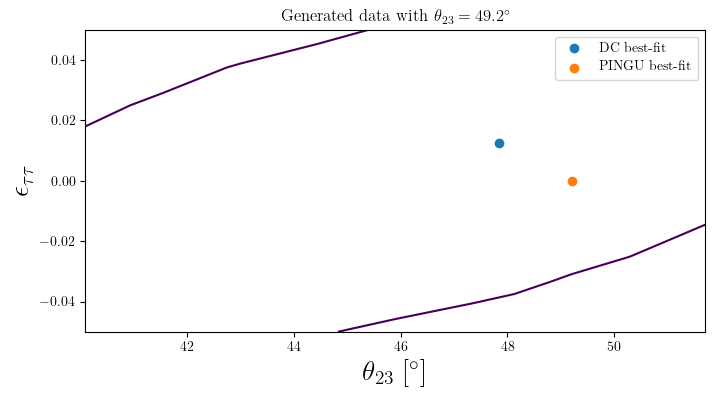

In [45]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.contour(th23_range*180/np.pi,ett_range, deltachi[0,0,0,:,:,0], levels=[chi2.ppf(0.9,1)])
ax.set_xlabel(r'$\theta_{23}$ [${}^\circ$]', fontsize=20)
ax.set_ylabel(r'$\epsilon_{\tau\tau}$', fontsize=20)
ax.scatter(47.84, 0.0125, label='DC best-fit')
ax.scatter(49.2, 0, label='PINGU best-fit')
ax.set_title('Generated data with ' + r'$\theta_{23}=49.2^\circ$')
ax.legend()

<a list of 2 text.Text objects>

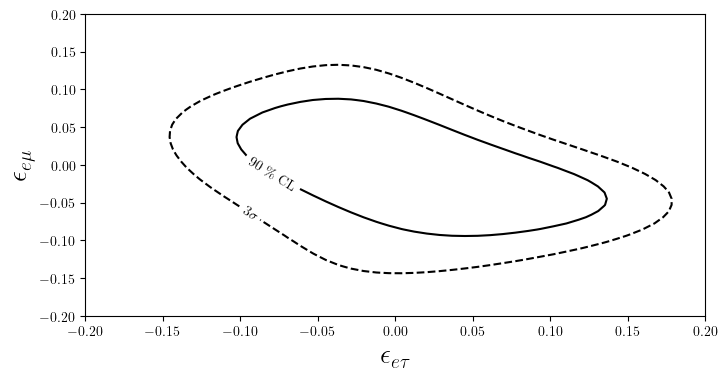

In [128]:
from scipy.interpolate import RectBivariateSpline
eet_eem = marginalized_deltachi[best_dm31_index, best_th23_index,:,:]
spl = RectBivariateSpline(eet_range,eem_range,eet_eem)
x2 = np.linspace(-2e-1,2e-1,50)
y2 = spl(x2, x2)
fig, ax = plt.subplots(1,1,figsize=(8,4))

im = ax.contour(x2,x2,y2, levels=[chi2.ppf(0.9,2),chi2.ppf(0.9973,2)],colors=['k','k'], linestyles = ['solid','dashed'])
#ax.contour(x2,x2,y2, levels=[chi2.ppf(0.9973,2)])
ax.set_xlabel(r'$\epsilon_{e\tau}$', fontsize=20)
ax.set_ylabel(r'$\epsilon_{e\mu}$', fontsize=20)


fmt_noerr = {}
strs = ['90\% CL', r'$3\sigma$']
for l, s in zip(im.levels, strs):
    fmt_noerr[l] = s
'''
fmt_fiverr = {}
strs = ['f=5 \%']
for l, s in zip(five_err.levels, strs):
    fmt_fiverr[l] = s
'''
ax.clabel(im, im.levels, inline=True, fmt=fmt_noerr, fontsize=10)
#ax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)

In [3]:
marginalized_arrays_NO=[]
marginalized_arrays_IO=[]
nsi_param_range=[]
N = 10 - 2
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
for ordering in ['NO','IO']:
    for i,nsi_param in enumerate(['ett','emt','eem','eet']):
        ettN,emtN,eemN,eetN = 0,0,0,0
        if nsi_param == 'ett':
            ettN = 1
        elif nsi_param == 'emt':
            emtN = 1
        elif nsi_param == 'eem':
            eemN = 1
        elif nsi_param == 'eet':
            eetN = 1
        dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N= 5, th23N = 5, 
                                                                                        ett = 5e-2, ettN = N*(ettN)+1,
                                                                                        emt = 2e-2, emtN = N*(emtN)+1,
                                                                                        eem = 2e-1, eemN = N*(eemN)+1,
                                                                                        eet = 2e-1 , eetN = N*(eetN)+1,
                                                                                        IO = True if ordering == 'IO' else False)
        param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
        param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range) 
        try:
            H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
            H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime

            marg_array = get_marginalized_array(H1,H0,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, nsi_param, sigma_a,sigma_b, f)
            if ordering == 'NO':
                marginalized_arrays_NO.append(marg_array)
            elif ordering == 'IO':
                marginalized_arrays_IO.append(marg_array)
            param_range = ettN*ett_range + emtN*emt_range + eemN*eem_range + eetN*eet_range #Assumes 3d plot
            nsi_param_range.append(param_range)
        except FileNotFoundError:
            pass #No IO found

$\epsilon_{\tau\tau}$
90CL: [-0.03]
3sigma: [-0.048]

$\epsilon_{\mu\tau}$
90CL: [-0.004  0.005]
3sigma: [-0.01   0.012]

$\epsilon_{e\mu}$
90CL: [-0.039  0.035]
3sigma: [-0.112  0.09 ]

$\epsilon_{e\tau}$
90CL: [-0.048  0.057]
3sigma: [-0.11   0.124]



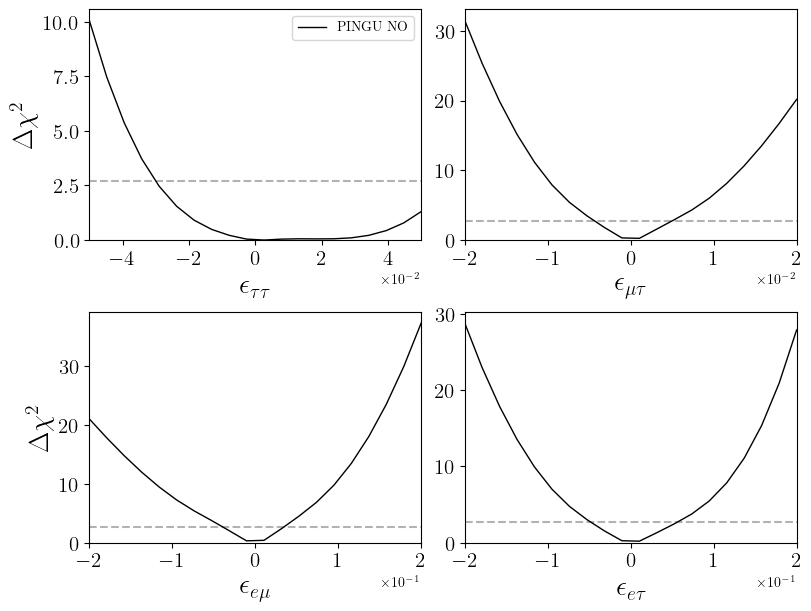

In [4]:
fig, ax = plt.subplots(2,2,figsize=(8,6), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20)
    interpolated_e = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20),splrep(nsi_param_range[i], marginalized_arrays_NO[i]))
    
    ax[i].plot(finer_e_range, interpolated_e, label='PINGU NO', color='k', lw=1)
    #ax[i].plot(nsi_param_range[i], marginalized_arrays_NO[i], label='PINGU NO', color='k', lw=1)
    #ax[i].plot(nsi_param_range[i], marginalized_arrays_IO[i], label='IO', color='green')
    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

    #ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    #ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=20)
    ax[i].tick_params(labelsize=15)
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    cl_90_bounds = splrep(nsi_param_range[i], marginalized_arrays_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds = splrep(nsi_param_range[i], marginalized_arrays_NO[i]- chi2.ppf(0.9973,1))
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds)}\n'+f'3sigma: {sproot(three_sigma_bounds)}\n')
ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[0].legend()
#save(fig, 'PINGU_3D_NO')
#savethesis(fig, 'PINGU_3D_NO')

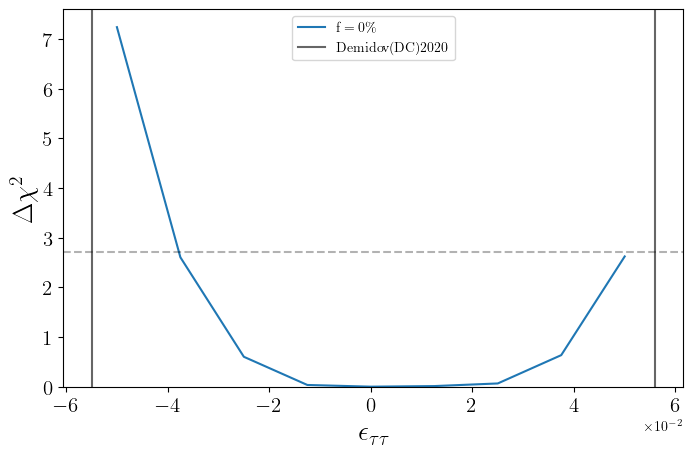

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
demidov_ett = (-0.055, 0.056)
plt.plot(ett_range, marginalized_deltachi[best_ett_index,0,0,0],label=r'$\mathrm{f = 0\%}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')


plt.axvline(demidov_ett[0], alpha=0.6,c='black', label=r'$\mathrm{Demidov (DC) 2020}$')
plt.axvline(demidov_ett[1], alpha=0.6,c='black')

plt.ylim(bottom=0)
plt.xlabel(r'$\epsilon_{\tau\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
#save(fig, 'PINGU_3D_ett')

In [7]:
print(deltachi_ett)
print(ett_range)
x1 = deltachi_ett[1]
x2 = deltachi_ett[2]
y2 = ett_range[2]
y1 = ett_range[1]

print((y2-y1)/(x2+x1) * chi2.ppf(0.9,1) + y1)
print(dm31_range[best_dm31_index],th23_range[best_th23_index]*180/np.pi)

[10.074  4.149  1.241  0.185  0.     0.034  0.05   0.264  1.304]
[-0.05  -0.038 -0.025 -0.012  0.     0.012  0.025  0.038  0.05 ]
-0.03122504271720813
0.002517 49.20000000000001


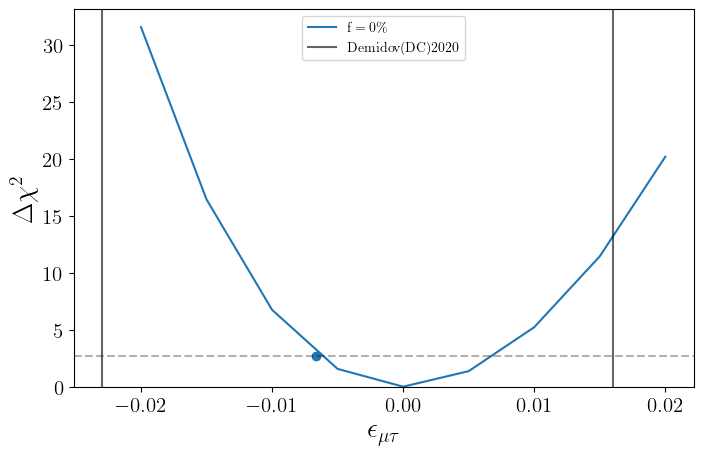

In [15]:
demidov_emt = (-0.023, 0.016)
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(emt_range, deltachi_emt,label=r'$\mathrm{f = 0\%}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov_emt[0], alpha=0.6,c='black', label=r'$\mathrm{Demidov (DC) 2020}$')
plt.axvline(demidov_emt[1], alpha=0.6,c='black')
#plt.scatter((y2-y1)/(x2+x1) * chi2.ppf(0.9,1) + y1, chi2.ppf(0.9,1))

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
#save(fig, 'PINGU_3D_emt')

In [26]:
print(deltachi_emt)
print(emt_range)
x1 = deltachi_emt[3]
x2 = deltachi_emt[2]
y1 = emt_range[3]
y2 = emt_range[2]

'''
print((y2-y1)/(x2-x1) *(chi2.ppf(0.9,1)) + y1)
x1 = deltachi_emt[5]
x2 = deltachi_emt[6]
y1 = emt_range[5]
y2 = emt_range[6]
'''

print((y2-y1)/(x2-x1) *chi2.ppf(0.9,1) + y1)
print(dm31_range[best_dm31_index],th23_range[best_th23_index]*180/np.pi)

[31.535 16.419  6.737  1.559  0.     1.362  5.218 11.435 20.17 ]
[-0.02  -0.015 -0.01  -0.005  0.     0.005  0.01   0.015  0.02 ]
-0.0076126236892207644
0.002517 49.20000000000001


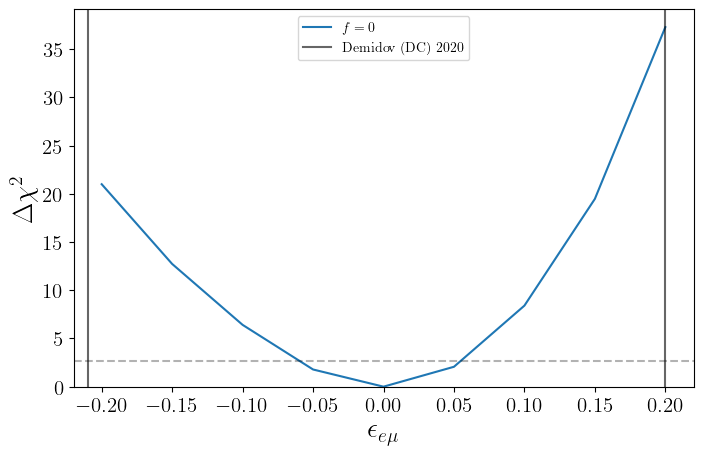

In [21]:
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(eem_range, deltachi_eem,label=rf'$f = {f}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
ax.axvline(demidov_eem[0], alpha=0.6,c='black', label=r'Demidov (DC) 2020')
ax.axvline(demidov_eem[1], alpha=0.6,c='black')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
ax.set_ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\epsilon_{e\mu}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.legend()
save(fig, 'PINGU_3D_eem')

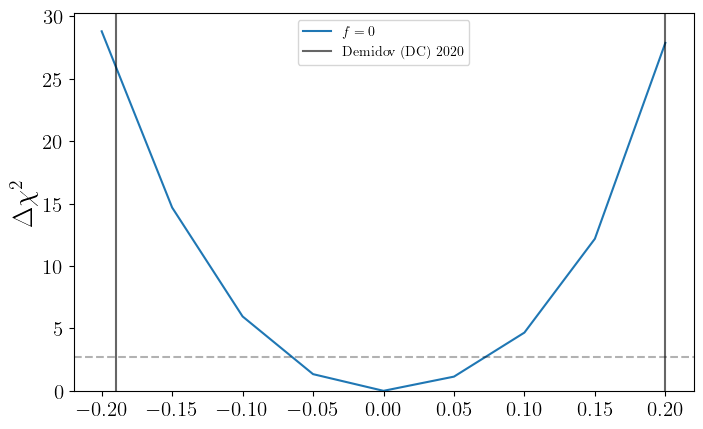

In [25]:
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(eet_range, deltachi_eet,label=rf'$f = {f}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
ax.axvline(demidov_eet[0], alpha=0.6,c='black', label=r'Demidov (DC) 2020')
ax.axvline(demidov_eet[1], alpha=0.6,c='black')
ax.set_ylim(bottom=0)
#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5$\epsilon_{e\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.legend()
#save(fig, 'PINGU_3D_eet')

In [15]:
H1[0,:,:,0:4]

array([[[1501.439, 1754.04 , 1906.802, 2271.716],
        [1086.642, 1261.793, 1479.374, 1739.425],
        [ 725.768,  765.004,  972.339, 1310.818],
        [ 423.068,  479.907,  640.462,  780.857],
        [ 242.26 ,  308.297,  421.37 ,  528.212],
        [ 165.895,  191.693,  282.103,  387.714],
        [ 108.669,  129.792,  206.376,  276.532],
        [  80.996,   91.867,  130.703,  176.622]],

       [[ 319.062,  338.08 ,  409.91 ,  497.159],
        [ 366.847,  404.583,  407.003,  667.564],
        [ 358.756,  312.692,  412.045,  597.407],
        [ 232.99 ,  243.871,  440.95 ,  653.16 ],
        [ 157.862,  247.251,  424.367,  631.312],
        [ 152.053,  255.607,  367.369,  507.704],
        [ 159.66 ,  205.934,  300.042,  436.903],
        [ 149.308,  170.916,  246.61 ,  323.395]]])

In [20]:
dm31_range, th23_range

(array([0.002, 0.002, 0.003, 0.003, 0.003]),
 array([0.7  , 0.767, 0.835, 0.859, 0.902]))

In [25]:
param_list[67]

{'theta_12': 0.5836381018669037,
 'theta_13': 0.14957471689591406,
 'theta_23': 0.8587019919812102,
 'theta_34': 0.0,
 'theta_24': 0.2013579207903308,
 'theta_14': 0.0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.42e-05,
 'dm_31': 0.002517,
 'dm_41': 0.93,
 'e_ee': 0,
 'e_em': 0.0,
 'e_et': 0.0,
 'e_mm': 0,
 'e_mt': -0.01,
 'e_tt': 0.0,
 'e_es': 0,
 'e_ms': 0,
 'e_ts': 0,
 'e_ss': 0}

In [7]:
ax.shape

(4,)

In [54]:
H1_DC = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
H0_DC = pickle.load(open(f'./pre_computed/H0_{ordering}_DC.p','rb'))*livetime
from matplotlib.colors import CenteredNorm
N_NSI_left = H1[67,:,:,0:5] #emt = -0.01, dm and th23 at nufit
N_NSI_left_DC = H1_DC[67,:,:,0:5]
N_SI = H0[:,:,0:5] #H0
N_SI_DC = H0_DC[:,:,0:5] #H0
pull_min = (N_SI - N_NSI_left)/np.sqrt(N_SI)
pull_minDC = (N_SI_DC - N_NSI_left_DC)/np.sqrt(N_SI_DC)
titles = [r'PINGU cascades', r'PINGU tracks', r'DC cascades', r'DC tracks']
fig, ax = plt.subplots(1,5,figsize=(16,5),sharex=True, sharey=True, squeeze=True)
pulls = [pull_min[0], pull_min[1], pull_minDC[0], pull_minDC[1]]
for pid in [0,1,2,3]:
    ax[pid].set_title(titles[pid], fontsize=20)
    im = ax[pid].pcolormesh(zbins_2018[0:5],Ebins_2018, pulls[pid], cmap='RdBu', vmin = -1.6, vmax=1.6, shading='auto')
    ax[pid].set_yscale('log')
    
    ax[pid].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
    ax[pid].set_yticks([], minor=True)
    ax[pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[pid].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #ax[pid].ticklabel_format(style='sci',axis='y')
    ax[pid].tick_params(which='both',labelsize=15)
    ax[pid].set_yticks(np.linspace(10,50,5))
    ax[pid].set_xticks(zbins_2018[0:5])
    ax[pid].tick_params(axis='both', direction='in', which='both')

plt.colorbar(imDC, ax=ax[4], pad = 0.9)

ax[0].set_ylabel(r'$E^{reco}$ [\si{\GeV}]', fontsize=20)
#ax2 = ax[3].twinx()
#ax2.set_yticks([])
#_=ax2.set_ylabel(r'$(N_{SI} - N_{NSI})/\sqrt{N_{SI}}$', fontsize=20, labelpad= 70)

#plt.suptitle(r'$[N(\epsilon_{\mu\tau}^-) - N(\epsilon_{\mu\tau}^+)]/\sqrt{N_{SI}}$ PINGU',fontsize=20)
ax[4].axis('off')
#save(fig,'event_pulls')

<ipython-input-54-cb1fc7e8b57b>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[pid].pcolormesh(zbins_2018[0:5],Ebins_2018, pulls[pid], cmap='RdBu', vmin = -1.6, vmax=1.6, shading='auto')


ZeroDivisionError: division by zero

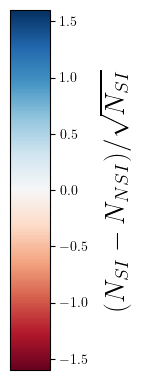

In [46]:
fig = plt.figure()
import matplotlib.cm as cm
#ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
ax = fig.add_axes([0.80,0.05,   0.05,0.9])
norm = matplotlib.colors.Normalize(vmin = -1.6, vmax = 1.6) 
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='vertical', cmap=cm.RdBu, norm = norm)

#ax2 = ax[3].twinx()
#ax2.set_yticks([])
_=ax.set_ylabel(r'$(N_{SI} - N_{NSI})/\sqrt{N_{SI}}$', fontsize=20, labelpad= 10)
save(fig, 'event_pulls_cbar')